In [1]:
import argparse
import RetrieveImage as retrieveImage
import os
import csv
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import *
import json
import pandas as pd
import metadata_preprocessing as processing
import xgboost as xgb
import DeepImageUtils as IU
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from matplotlib import pyplot as plt
import seaborn as sns # for correlation heatmap
import shap
from xgboost import XGBRegressor

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
np.random.seed(123)
from sklearn.inspection import permutation_importance

2021-10-14 10:32:45.009303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = os.path.abspath(globals()['_dh'][0] + '/..') + '/Data'
# images_path = "/ceph/csedu-scratch/project/akaradathodi/Images/"
images_path = os.path.abspath(data_path + '/../../') + '/Images/'

image_features_path = os.path.abspath(globals()['_dh'][0] + '/..') + '/Data/total_features.npz'

In [17]:
df = pd.read_csv(data_path + '/updated_ecommerce_data_feature_importance.csv')
x_train = df.drop(['price'], axis=1)
y_train = df['price']


In [4]:
x_train.iloc[0]

Unnamed: 0                                                           0
uniq_id                               cc51c3dd925d9d84e2fb28c7918dbbc3
crawl_timestamp                              2019-08-11 05:49:46 +0000
product_id                                                     6937673
link                 https://www.myntra.com/tops/imara/imara-women-...
size                                                                XL
variant_sku                                                 6937673_XL
brand                                                            IMARA
care_instructions                                Polyester | Dry-clean
dominant_material                                            Polyester
title                                      IMARA Women Black Solid Top
actual_color                                                     Black
dominant_color                                                   Black
product_type                                                       Top
images

In [18]:
columns_to_remove = ['Unnamed: 0','uniq_id','crawl_timestamp','link', 'images', 'body', 'category', 'image_0', 'image_1', 'image_2']
x_train.drop(columns_to_remove, inplace=True, axis=1, errors='ignore')
x_train.iloc[0]

product_id                                                     6937673
size                                                                XL
variant_sku                                                 6937673_XL
brand                                                            IMARA
care_instructions                                Polyester | Dry-clean
dominant_material                                            Polyester
title                                      IMARA Women Black Solid Top
actual_color                                                     Black
dominant_color                                                   Black
product_type                                                       Top
product_details      Black solid woven regular top,has a V-neck, th...
size_fit                   The model (height 5'8") is wearing a size S
complete_the_look    Improve your personal style with a brand new t...
variant_price                                                      959
gender

In [19]:
def process_care_inst(input_data):
    count = 0
    for i in range(3):
        def get_categories(ele):

            if type(ele) != str:
                return np.nan

            cat = ele.split('|')

            if i >= len(cat):
                return np.nan
            else:
                return cat[i]

        col_name = 'care_instruction_' + str(count)
        count += 1

        input_data[col_name] = input_data['care_instructions'].apply(get_categories)

        input_data.fillna({'category_name': 'Other'}, inplace = True)

process_care_inst(x_train)
x_train.iloc[0]

product_id                                                      6937673
size                                                                 XL
variant_sku                                                  6937673_XL
brand                                                             IMARA
care_instructions                                 Polyester | Dry-clean
dominant_material                                             Polyester
title                                       IMARA Women Black Solid Top
actual_color                                                      Black
dominant_color                                                    Black
product_type                                                        Top
product_details       Black solid woven regular top,has a V-neck, th...
size_fit                    The model (height 5'8") is wearing a size S
complete_the_look     Improve your personal style with a brand new t...
variant_price                                                   

In [20]:
columns_to_remove = ['care_instruction_2','care_instructions']
x_train.drop(columns_to_remove, inplace=True, axis=1, errors='ignore')
x_train.iloc[0]

product_id                                                      6937673
size                                                                 XL
variant_sku                                                  6937673_XL
brand                                                             IMARA
dominant_material                                             Polyester
title                                       IMARA Women Black Solid Top
actual_color                                                      Black
dominant_color                                                    Black
product_type                                                        Top
product_details       Black solid woven regular top,has a V-neck, th...
size_fit                    The model (height 5'8") is wearing a size S
complete_the_look     Improve your personal style with a brand new t...
variant_price                                                       959
gender                                                          

In [21]:
columns_to_remove = ['title','product_details','size_fit','complete_the_look', 'specifications']
x_train.drop(columns_to_remove, inplace=True, axis=1, errors='ignore')
x_train.iloc[0]

product_id                 6937673
size                            XL
variant_sku             6937673_XL
brand                        IMARA
dominant_material        Polyester
actual_color                 Black
dominant_color               Black
product_type                   Top
variant_price                  959
gender                       Women
is_in_stock           Out of Stock
inventory                        0
images_count                     4
category_0                Clothing
category_1                    Tops
luxurious_brands             False
expensive_brands             False
cheap_brands                  True
care_instruction_0      Polyester 
care_instruction_1       Dry-clean
Name: 0, dtype: object

In [9]:
label_encoder = LabelEncoder()
x_train.iloc[:,0] = label_encoder.fit_transform(x_train.iloc[:,0]).astype('float64')

In [11]:
corr = x_train.corr()

<AxesSubplot:>

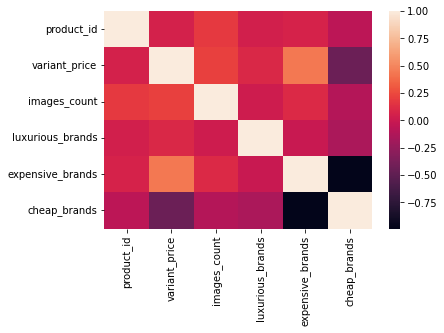

In [12]:
sns.heatmap(corr)

In [13]:
x_train

,product_id,size,variant_sku,brand,dominant_material,actual_color,dominant_color,product_type,variant_price,gender,is_in_stock,inventory,images_count,category_0,category_1,luxurious_brands,expensive_brands,cheap_brands,care_instruction_0,care_instruction_1
0,5364.0,XL,6937673_XL,IMARA,Polyester,Black,Black,Top,959,Women,Out of Stock,0,4,Clothing,Tops,False,False,True,Polyester,Dry-clean
1,6690.0,XL,7441182_XL,House of Pataudi,cotton,Black,Black,Straight Kurta,799,Men,In Stock,Shape : Straight | Sleeve Styling : Regular Sl...,3,Clothing,Kurtas,False,False,True,100% cottonMachine-wash,NaN
2,199.0,Onesize,1314889_Onesize,Dupatta Bazaar,Chiffon,Pink,Pink,Dupatta,349,Women,In Stock,Pattern : Solid | Occasion : Daily | Border : ...,2,Clothing,Dupatta,False,False,True,Chiffon,Hand-wash
3,1955.0,L,2160958_L,Wintage,Linen,Beige,Beige,Kurta with Pyjamas,979,Men,Out of Stock,0,4,Clothing,Kurta Sets,False,False,True,Kurta fabric: linen,Bottom fabric: pure cotton
4,7692.0,34,7766518_34,Geroo Jaipur,NaN,Green,Green,NaN,1572,Women,Out of Stock,Knit or Woven : Knitted and Woven | Transparen...,4,Clothing,Skirts,False,False,True,First wash dry clean than after hand wash,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10754,2672.0,M,2366741_M,Shree,Liva,Red | Grey,Grey,Maxi Dress,764,Women,Out of Stock,0,4,Clothing,Dresses,False,False,True,100% LivaHand-wash,NaN
10755,4639.0,XL,6554346_XL,Freehand,Cotton,Red | White,Red,Kurta with Pyjamas,919,Men,Out of Stock,0,4,Clothing,Kurta Sets,False,False,True,Top fabric: Pure Cotton,Bottom fabric: Pure Cotton
10756,4195.0,XXL,5504617_XXL,Shakumbhari,Cotton,Pink,Pink,A-Line Kurta,627,Women,Out of Stock,0,4,Clothing,Kurtas,False,False,True,Cotton,Machine-wash
10757,3843.0,M,4375262_M,Anouk,acrylic,Green,Green,Cardigan,759,Women,Out of Stock,0,4,Clothing,Sweaters,False,False,True,100% acrylic,Machine-wash


In [43]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import OneHotEncoder
# cat_attribs = ['product_id','size', 'brand', 'dominant_material', 'dominant_color', 'product_type', 'gender', 'is_in_stock', 'category_0', 'category_1', 'care_instruction_0', 'care_instruction_1', 'variant_price','']
# full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

In [22]:
# columns_to_remove = ['variant_sku','actual_color','inventory']
columns_to_remove = ['variant_price']
x_train.drop(columns_to_remove, inplace=True, axis=1, errors='ignore')
x_train.iloc[0]


product_id                 6937673
size                            XL
variant_sku             6937673_XL
brand                        IMARA
dominant_material        Polyester
actual_color                 Black
dominant_color               Black
product_type                   Top
gender                       Women
is_in_stock           Out of Stock
inventory                        0
images_count                     4
category_0                Clothing
category_1                    Tops
luxurious_brands             False
expensive_brands             False
cheap_brands                  True
care_instruction_0      Polyester 
care_instruction_1       Dry-clean
Name: 0, dtype: object

In [64]:
col = list(x_train.columns.values)

In [51]:
# encoder = full_pipeline.fit(x_train)
# x_train = encoder.transform(x_train)

ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [24]:
print(x_train.dtypes)

product_id            int64
size                  int64
variant_sku           int64
brand                 int64
dominant_material     int64
actual_color          int64
dominant_color        int64
product_type          int64
gender                int64
is_in_stock           int64
inventory             int64
images_count          int64
category_0            int64
category_1            int64
luxurious_brands       bool
expensive_brands       bool
cheap_brands           bool
care_instruction_0    int64
care_instruction_1    int64
dtype: object


In [23]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
x_train['size'] = lbl.fit_transform(x_train['size'].astype(str))
x_train['brand'] = lbl.fit_transform(x_train['brand'].astype(str))
x_train['dominant_material'] = lbl.fit_transform(x_train['dominant_material'].astype(str))
x_train['dominant_color'] = lbl.fit_transform(x_train['dominant_color'].astype(str))
x_train['product_type'] = lbl.fit_transform(x_train['product_type'].astype(str))
x_train['gender'] = lbl.fit_transform(x_train['gender'].astype(str))
x_train['is_in_stock'] = lbl.fit_transform(x_train['is_in_stock'].astype(str))
x_train['category_0'] = lbl.fit_transform(x_train['category_0'].astype(str))
x_train['category_1'] = lbl.fit_transform(x_train['category_1'].astype(str))
x_train['care_instruction_0'] = lbl.fit_transform(x_train['care_instruction_0'].astype(str))
x_train['care_instruction_1'] = lbl.fit_transform(x_train['care_instruction_1'].astype(str))
x_train['inventory'] = lbl.fit_transform(x_train['inventory'].astype(str))
x_train['actual_color'] = lbl.fit_transform(x_train['actual_color'].astype(str))
x_train['variant_sku'] = lbl.fit_transform(x_train['variant_sku'].astype(str))

In [25]:
xgb = XGBRegressor(n_estimators=500)
xgb_params = {'gamma': 0.2, 'reg_lambda': 0.5, 'learning_rate': 0.07,
              'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.6,
              'max_depth': 6}
xgb.set_params(**xgb_params)
xgb.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0.2, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0.6, reg_lambda=0.5, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [27]:
xgb.feature_importances_

array([0.00336449, 0.00237902, 0.0037598 , 0.00990799, 0.00571787,
       0.00232511, 0.00322487, 0.00704703, 0.04324364, 0.00446452,
       0.0026159 , 0.006089  , 0.        , 0.0429659 , 0.05553487,
       0.02108478, 0.77509576, 0.00619059, 0.00498885], dtype=float32)

In [16]:
x_train.columns

Index(['product_id', 'size', 'variant_sku', 'brand', 'dominant_material',
       'actual_color', 'dominant_color', 'product_type', 'variant_price',
       'gender', 'is_in_stock', 'inventory', 'images_count', 'category_0',
       'category_1', 'luxurious_brands', 'expensive_brands', 'cheap_brands',
       'care_instruction_0', 'care_instruction_1'],
      dtype='object')

<BarContainer object of 17 artists>

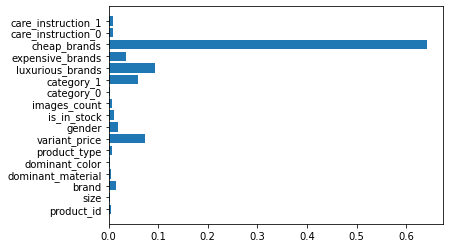

In [80]:
plt.barh(x_train.columns, xgb.feature_importances_)

Text(0.5, 0, 'Xgboost Feature Importance')

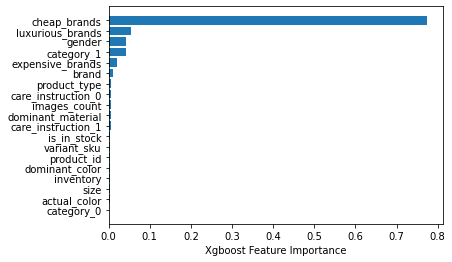

In [36]:
sorted_idx = xgb.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_idx], xgb.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [37]:
xgb = XGBRegressor(n_estimators=500)
xgb_params = {'gamma': 0.2, 'reg_lambda': 0.5, 'learning_rate': 0.07,
              'subsample': 0.7, 'colsample_bytree': 0.9, 'reg_alpha': 0.6,
              'max_depth': 6}
xgb.set_params(**xgb_params)
xgb.fit(x_train, y_train)
perm_importance = permutation_importance(xgb, x_train, y_train)

In [ ]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="ocean",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(x_train[x_train.columns[sorted_idx]])

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_train)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, x_train)


Text(0.5, 0, 'Permutation Importance')

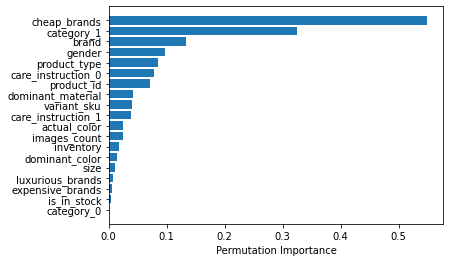

In [38]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

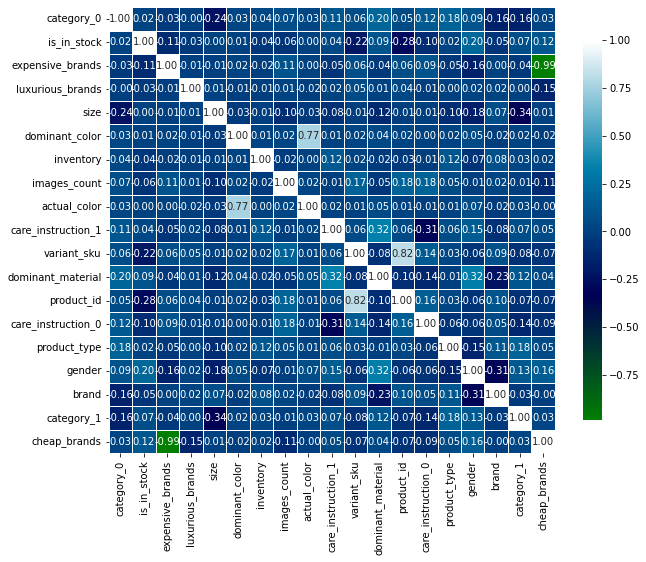

In [62]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="ocean",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(x_train[x_train.columns[sorted_idx]])

In [63]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_train)

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, x_train)


Text(0.5, 0, 'Permutation Importance')

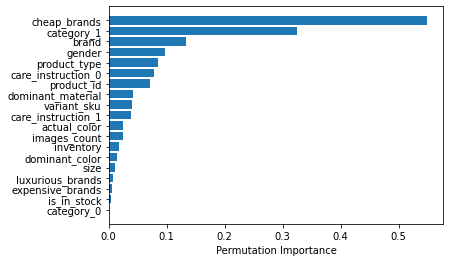

In [64]:
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(x_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

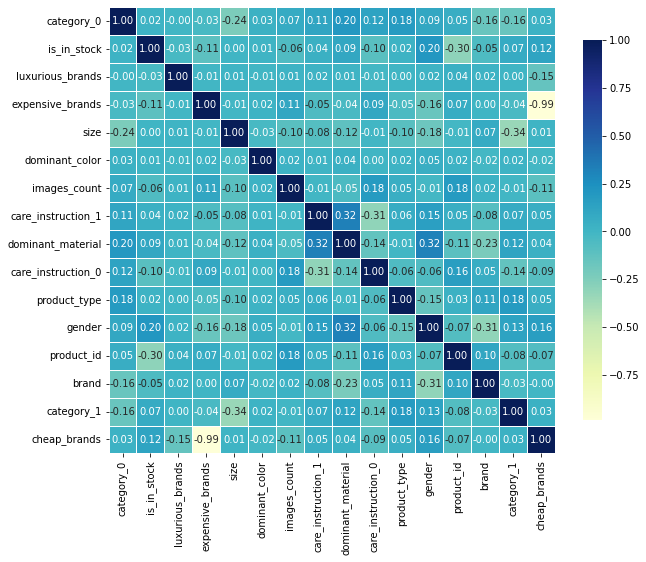

In [97]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(x_train[x_train.columns[sorted_idx]])

In [65]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_train)

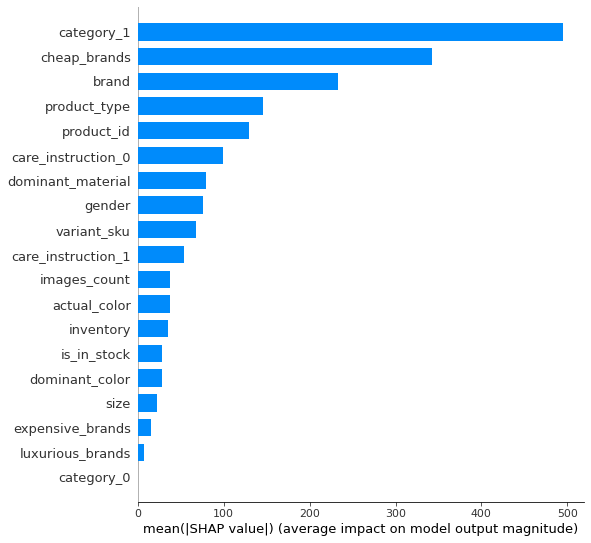

In [66]:
shap.summary_plot(shap_values, x_train, plot_type="bar")

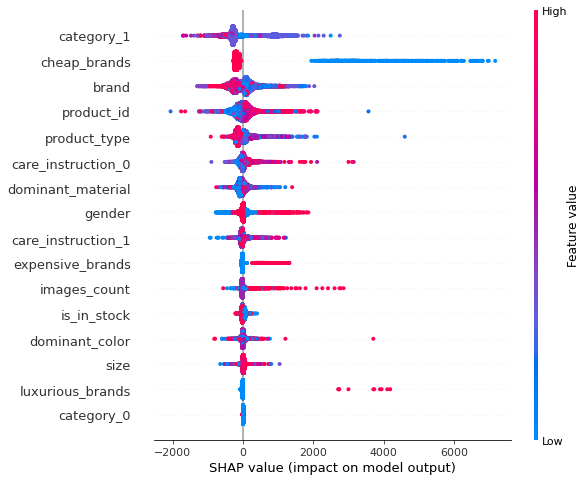

In [104]:
shap.summary_plot(shap_values, x_train)
